# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [186]:
import os
import cv2
from PIL import Image
import optuna
import atom.data_cleaning as dc
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchinfo import summary
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [166]:
path = '../data/images'
pixels_per_side = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [167]:
print("Using device: ", device)

Using device:  cuda


## Dataset loading and preprocessing

In [168]:
data = []
labels = []
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (pixels_per_side, pixels_per_side))
    data.append(img)
    labels.append(int(file[:3]) - 1)
labels = np.array(labels)
classes = ['Danaus plexippus', 'Heliconius charitonius', 'Heliconius erato', 'Junonia coenia', 'Lycaena phlaeas',
           'Nymphalis antiopa', 'Papilio cresphontes', 'Pieris rapae', 'Vanessa atalanta', 'Vanessa cardui']

In [169]:
print([classes[labels[i]] for i in range(10)])

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


In [171]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = Image.fromarray(data, mode='RGB')
        if self.transform:
            data = self.transform(data)
        labels = torch.tensor(self.labels[idx])
        return data, labels

In [172]:
trans = transforms.Compose([
    transforms.ToTensor()
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
total_sum = torch.zeros(3)
total_count = 0
for images, _ in dataloader:
    total_sum += images.sum(dim=[0, 2, 3])
    total_count += images.numel() / images.shape[1]
mean = total_sum / total_count
sum_of_squared_diff = torch.zeros(3)
for images, _ in dataloader:
    sum_of_squared_diff += ((images - mean.unsqueeze(1).unsqueeze(2))**2).sum(dim=[0, 2, 3])
std = torch.sqrt(sum_of_squared_diff / total_count)
mean = [mean[0].item(), mean[1].item(), mean[2].item()]
std = [std[0].item(), std[1].item(), std[2].item()]

In [173]:
print(mean, std)

[0.4616279900074005, 0.4468429684638977, 0.3207762539386749] [0.2861473262310028, 0.2681962549686432, 0.27681371569633484]


Display some samples

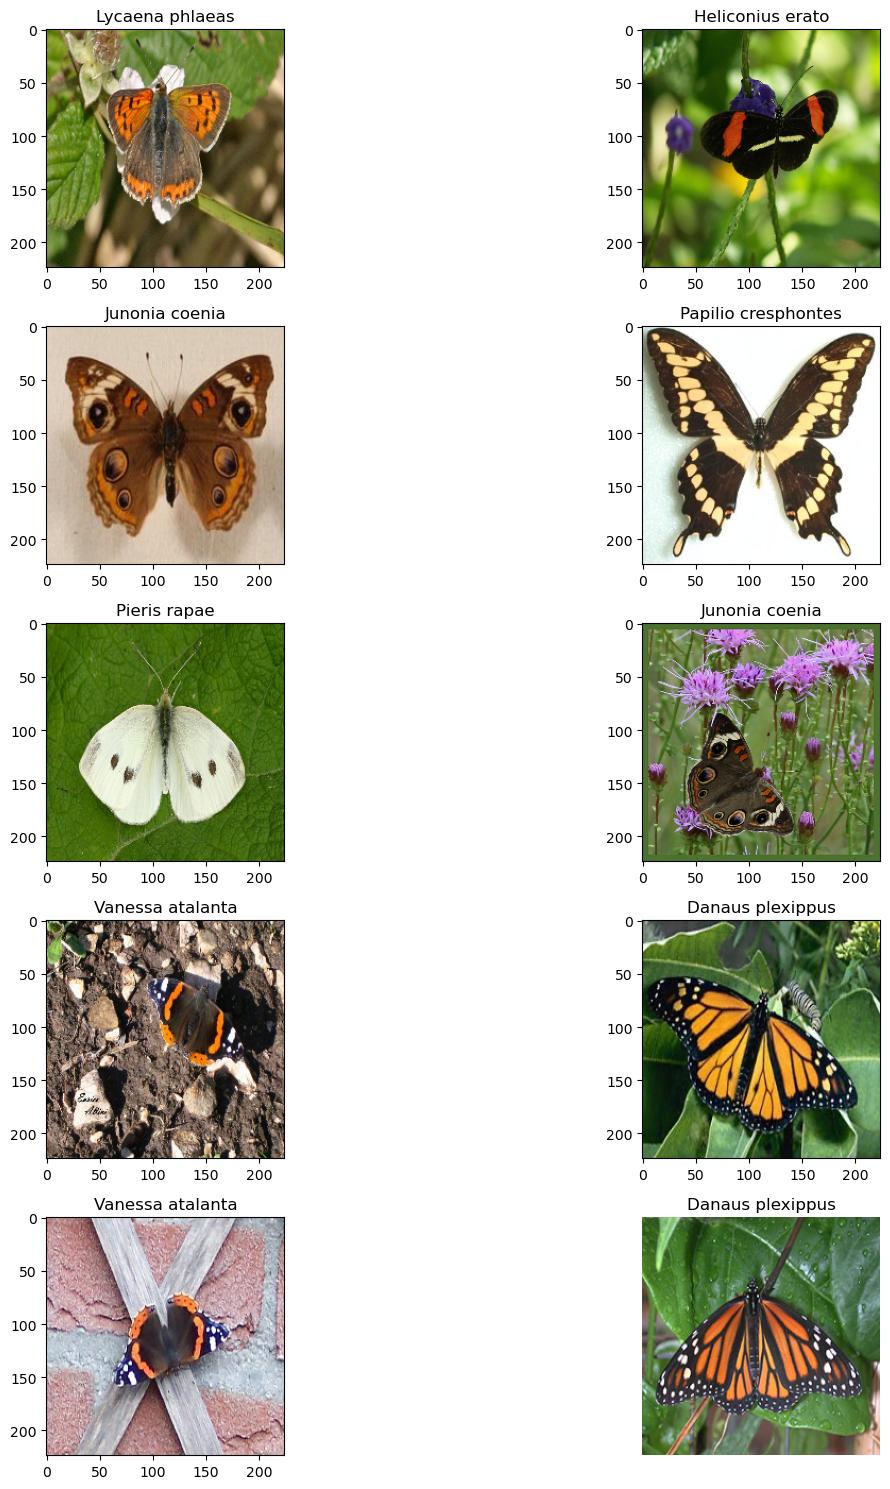

In [174]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(classes[labels[l]]))
plt.axis('off')        
plt.tight_layout()

Display dataset distribution

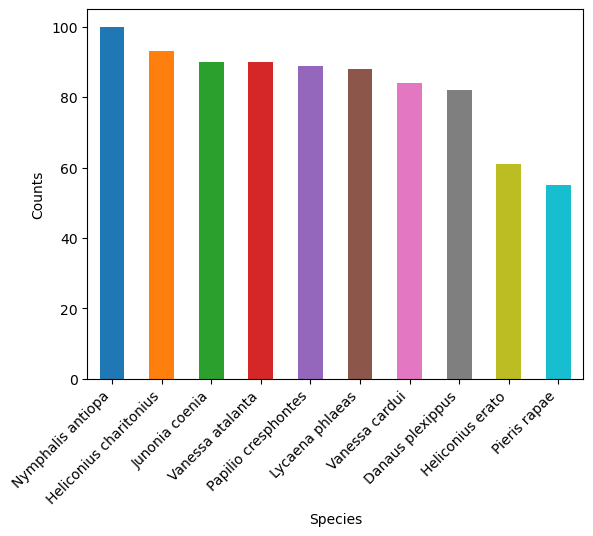

In [175]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = df['labels'].map(classes)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

### Data cleaning

Use this to check dataset shape

In [179]:
print(data.shape, labels.shape)
print(data)
print(labels)

(820, 224, 224, 3) (820,)
[[[[-0.8457886  -0.7635603  -0.6676272 ]
   [-0.5991036  -0.5168753  -0.5031706 ]
   [-0.54428476 -0.5031706  -0.434647  ]
   ...
   [ 0.20947485  0.14095125  0.0313134 ]
   [ 0.00390397  0.0313134   0.01760869]
   [-0.03721019 -0.10573377  0.18206541]]

  [[-0.61280835 -0.61280835 -0.7224461 ]
   [-0.6539225  -0.6402178  -0.5853989 ]
   [-0.53058004 -0.48946586 -0.48946586]
   ...
   [ 0.08613227  0.0313134  -0.02350547]
   [-0.0509149  -0.03721019 -0.07832434]
   [-0.11943849 -0.2701904  -0.31130454]]

  [[-0.18796209 -0.00980075 -0.0509149 ]
   [-0.3661234  -0.6539225  -0.6402178 ]
   [-0.5853989  -0.5716942  -0.5716942 ]
   ...
   [ 0.07242756 -0.00980075 -0.02350547]
   [-0.14684793 -0.17425737 -0.2016668 ]
   [-0.2838951  -0.39353284 -0.5031706 ]]

  ...

  [[-0.63464415 -0.8896469  -0.87548006]
   [-0.8329796  -0.77631235 -0.5921437 ]
   [-0.30880743 -0.20963968 -0.20963968]
   ...
   [-0.8188128  -0.80464596 -0.74797875]
   [-0.6204773  -0.4646424  -0.

Scaling the Feature Set: standardize your dataset to ensure all features are on a similar scale.

In [176]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
data = []
for img, _ in dataloader:
    data.append(img.numpy())
data = np.concatenate(data, axis=0)
data = data.reshape(len(data), -1)

Handling Outliers: detect and manage outliers in your dataset.

In [177]:
data, labels = (dc.Pruner(strategy=['lof', 'iforest'],
                          device='cpu',
                          engine='sklearn',
                          verbose=2,
                          iforest={'contamination': 'auto', 'bootstrap': True, 'n_jobs': -1, 'random_state': 1},
                          lof={'n_neighbors': 20, 'contamination': 'auto', 'n_jobs': -1}
                          )
                .fit_transform(data, labels))

Fitting Pruner...
Pruning outliers...
 --> The LocalOutlierFactor detected 12 outliers.
 --> The IsolationForest detected 276 outliers.
 --> Dropping 12 outliers.


In [178]:
data = data.values.reshape(-1, pixels_per_side, pixels_per_side, 3)
labels = labels.values

## Training pipeline

Split into training data and test data

In [180]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
trainset, testset = random_split(dataset, [0.85, 0.15])
testloader = DataLoader(testset, batch_size=64, shuffle=False)

(820, 224, 224, 3)
torch.Size([3, 224, 224])


CNN definition

In [181]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120 * 49 * 49, 64) # ((224 -4)/2 -4)/2 -4
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)
summary(net, input_size=(1, 3, pixels_per_side, pixels_per_side))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 220, 220]          456
├─MaxPool2d: 1-2                         [1, 6, 110, 110]          --
├─Conv2d: 1-3                            [1, 16, 106, 106]         2,416
├─MaxPool2d: 1-4                         [1, 16, 53, 53]           --
├─Conv2d: 1-5                            [1, 120, 49, 49]          48,120
├─Flatten: 1-6                           [1, 288120]               --
├─Linear: 1-7                            [1, 64]                   18,439,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 18,491,386
Trainable params: 18,491,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 183.19
Input size (MB): 0.60
Forward/backward pass size (MB): 6.07
Params size (MB): 73.97
Estimated Total Size (MB): 80.63

Train and validate methods

In [182]:
def fit(net, trainloader, optimizer, loss_fn=nn.CrossEntropyLoss()):
    net.train()
    total_loss = acc = count = 0
    for features, labels in trainloader:
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count

def predict(net, valloader, loss_fn):
    net.eval()
    count = acc = total_loss = 0
    with torch.no_grad():
        for features, labels in valloader:
            features = features.to(device)
            labels = labels.to(device)
            count += len(labels)
            out = net(features)
            total_loss += loss_fn(out, labels)
            pred = torch.max(out, 1)[1]
            acc += (pred == labels).sum()
    return total_loss.item() / count, acc.item() / count

Objective method for k fold cross validation

In [183]:
def objective(trial, net, trainset, X, y):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    epochs = trial.suggest_int('epochs', 5, 50)
    optimizer = getattr(optim, trial.suggest_categorical('optimizer', ['SGD', 'Adam']))(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    val_accs = []
    for train_index, val_index in skf.split(X, y):
        train_data = Subset(trainset, train_index)
        val_data = Subset(trainset, val_index)
        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            train_loss, train_acc = fit(net, trainloader, optimizer, criterion)
            val_loss, val_acc = predict(net, valloader, criterion)
            print(f"Epoch {epoch + 1:2}, Train acc={train_acc:.3f}, Val acc={val_acc:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
        val_accs.append(val_acc)
    return np.mean(val_accs)

In [ ]:
X = np.zeros(len(trainset))
labelloader =  DataLoader(trainset, batch_size=64, shuffle=False)
y = []
for _, label in labelloader:
    y.append(label.numpy())
y = np.concatenate(y, axis=0)
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, net, trainset, X, y), n_trials=10)

/tmp/ipykernel_13974/4197391195.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch  1, Train acc=0.140, Val acc=0.071, Train loss=0.019, Val loss=0.018
Epoch  2, Train acc=0.083, Val acc=0.100, Train loss=0.013, Val loss=0.016
Epoch  3, Train acc=0.104, Val acc=0.121, Train loss=0.012, Val loss=0.016
Epoch  4, Train acc=0.120, Val acc=0.093, Train loss=0.012, Val loss=0.016
Epoch  5, Train acc=0.117, Val acc=0.143, Train loss=0.012, Val loss=0.016
Epoch  6, Train acc=0.133, Val acc=0.164, Train loss=0.012, Val loss=0.016
Epoch  7, Train acc=0.153, Val acc=0.150, Train loss=0.012, Val loss=0.016
Epoch  8, Train acc=0.127, Val acc=0.157, Train loss=0.012, Val loss=0.016
Epoch  9, Train acc=0.192, Val acc=0.129, Train loss=0.012, Val loss=0.016
Epoch 10, Train acc=0.129, Val acc=0.129, Train loss=0.012, Val loss=0.016
Epoch 11, Train acc=0.129, Val acc=0.150, Train loss=0.012, Val loss=0.016
Epoch 12, Train acc=0.172, Val acc=0.150, Train loss=0.012, Val loss=0.016
Epoch 13, Train acc=0.131, Val acc=0.129, Train loss=0.012, Val loss=0.016
Epoch 14, Train acc=0.131

/tmp/ipykernel_13974/4197391195.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch  1, Train acc=0.566, Val acc=0.686, Train loss=0.008, Val loss=0.006
Epoch  2, Train acc=0.706, Val acc=0.657, Train loss=0.005, Val loss=0.007
Epoch  3, Train acc=0.847, Val acc=0.686, Train loss=0.003, Val loss=0.007
Epoch  4, Train acc=0.867, Val acc=0.636, Train loss=0.003, Val loss=0.008
Epoch  5, Train acc=0.919, Val acc=0.557, Train loss=0.002, Val loss=0.009
Epoch  1, Train acc=0.833, Val acc=0.964, Train loss=0.003, Val loss=0.001
Epoch  2, Train acc=0.883, Val acc=0.971, Train loss=0.002, Val loss=0.001
Epoch  3, Train acc=0.937, Val acc=0.957, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.957, Val acc=0.964, Train loss=0.001, Val loss=0.001
Epoch  5, Train acc=0.978, Val acc=0.950, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.977, Val acc=0.971, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.987, Val acc=0.971, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.989, Val acc=0.978, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.993

/tmp/ipykernel_13974/4197391195.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch  1, Train acc=0.531, Val acc=0.157, Train loss=0.485, Val loss=0.249
Epoch  2, Train acc=0.246, Val acc=0.300, Train loss=0.100, Val loss=0.035
Epoch  3, Train acc=0.321, Val acc=0.250, Train loss=0.019, Val loss=0.018
Epoch  4, Train acc=0.382, Val acc=0.164, Train loss=0.012, Val loss=0.016
Epoch  5, Train acc=0.332, Val acc=0.164, Train loss=0.011, Val loss=0.016
Epoch  6, Train acc=0.266, Val acc=0.114, Train loss=0.012, Val loss=0.016
Epoch  7, Train acc=0.230, Val acc=0.136, Train loss=0.012, Val loss=0.016
Epoch  8, Train acc=0.300, Val acc=0.164, Train loss=0.011, Val loss=0.017
Epoch  9, Train acc=0.330, Val acc=0.186, Train loss=0.011, Val loss=0.017
Epoch 10, Train acc=0.375, Val acc=0.200, Train loss=0.011, Val loss=0.016
Epoch 11, Train acc=0.521, Val acc=0.214, Train loss=0.010, Val loss=0.016
Epoch 12, Train acc=0.636, Val acc=0.200, Train loss=0.009, Val loss=0.015
Epoch 13, Train acc=0.664, Val acc=0.221, Train loss=0.008, Val loss=0.016
Epoch 14, Train acc=0.684

/tmp/ipykernel_13974/4197391195.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch  1, Train acc=0.993, Val acc=0.993, Train loss=0.001, Val loss=0.002
Epoch  2, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.002
Epoch  3, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.002
Epoch  4, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.002
Epoch  5, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.002
Epoch  6, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.002
Epoch  7, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.002
Epoch  8, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.001
Epoch  9, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.001
Epoch 10, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.001
Epoch 11, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.001
Epoch 12, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.002
Epoch 13, Train acc=1.000, Val acc=0.993, Train loss=0.000, Val loss=0.002
Epoch 14, Train acc=1.000

/tmp/ipykernel_13974/4197391195.py:2: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch  1, Train acc=0.996, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.996, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.996, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.996, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  5, Train acc=0.998, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  6, Train acc=0.998, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  7, Train acc=0.998, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  8, Train acc=0.998, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  9, Train acc=0.998, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch 10, Train acc=0.998, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch 11, Train acc=1.000, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch 12, Train acc=1.000, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  1, Train acc=1.000, Val acc=1.000, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=1.000